# Emerging Technologies Project

The following notebook trains a model that can be used to predict power output from wind speed values, as defined in the `powerproduction` dataset.

## Preamble

I'll begin by importing the necessary packages and reading in the dataset.

In [1]:
import tensorflow.keras as kr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Plot style
plt.style.use("ggplot")

# Plot size
plt.rcParams["figure.figsize"] = [14, 8]

In [3]:
# Read in the dataset
df = pd.read_csv("./powerproduction.csv")

# Print the first few rows
df.head(8)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826


Next I'll partition the dataset into two subsets. The first will be used to fit the model and is referred to as the training dataset, while the second will instead be used to make predictions based on the training data. The objective of splitting the data is to provide a way to estimate the performance of the machine learning model when it is presented with new data, i.e. data that wasn't used to train the model [1].

The training set will make up 80% of the total items in the overall dataset.

In [4]:
# Create train and test sets
# Reference: TensorFlow documentation
# https://www.tensorflow.org/tutorials/keras/regression#split_the_data_into_train_and_test
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

print("Training:")
print(train.head())
print("\nTesting:")
print(test.head())

Training:
      speed    power
90    4.905    7.060
254  12.713   51.149
283  14.489   71.763
445  22.422   99.357
461  23.273  113.556

Testing:
    speed  power
9   0.526  5.553
25  1.051  2.085
28  1.151  1.208
31  1.301  0.000
32  1.401  4.156


In order to better visualise the training and testing data sets we can plot them both using Matplotlib.

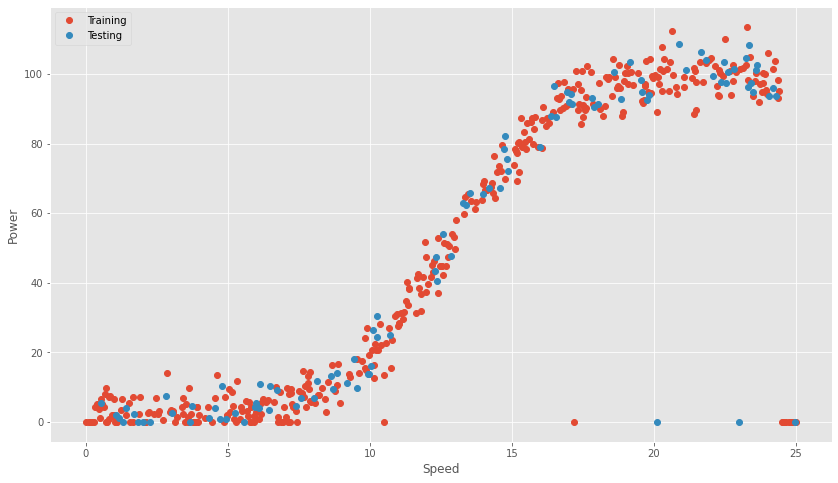

In [5]:
plt.plot(
    train.speed,
    train.power,
    "o",
    label="Training"
)

plt.plot(
    test.speed, 
    test.power,
    "o",
    label="Testing"
)

plt.xlabel("Speed")
plt.ylabel("Power")

plt.legend(loc="upper left");

When plotting the data, we'll notice that there are some outliers that may reduce the accuracy of our model. One possibility for these values could be maintenance work being carried out on the turbines. However, an article from the US Office of Energy Efficiency and Renewable Energy suggests that as wind speed increases, wind turbines generate more power until a limit is reached, known as the rated speed [2]. By looking at the plot above, the maximum power output observed appears to be approximately 100 with a speed of around 20-25.

Once the rated speed is reached, the power output should remain relatively stable until eventually a cut-out speed is reached, whereupon the turbine will shut down to prevent damage [2]. This could provide an explanation for the cluster of zero values that appear as the speed approaches a value of 25.

## Creating a Linear Model

Now I'll construct a linear modal and attempt to use it in order to make predictions. This is done below using Keras' `Sequential` class, which represents a linear grouping of layers [3]. The model created below contains a single dense layer. A dense layer is a layer in neural network that’s fully connected, meaning all the neurons in one layer are connected to all other neurons in the next layer [3].

In [6]:
model = kr.models.Sequential()

# Add a single dense layer
model.add(
    kr.layers.Dense(
        1,
        input_shape=(1,),
        activation="linear",
        kernel_initializer="ones",
        bias_initializer="zeros"
    )
)

# Compile the model
model.compile("adam", loss="mean_squared_error")

In [7]:
# Train the neural network on the training data
model.fit(
    train.speed,
    train.power,
    epochs=150,
    batch_size=10
)

Epoch 1/150
40/40 [==============================] - 2s 1ms/step - loss: 2537.9263
Epoch 2/150
40/40 [==============================] - 0s 707us/step - loss: 2330.8624
Epoch 3/150
40/40 [==============================] - 0s 725us/step - loss: 2372.8825
Epoch 4/150
40/40 [==============================] - 0s 966us/step - loss: 2573.6036
Epoch 5/150
40/40 [==============================] - 0s 897us/step - loss: 2289.4484
Epoch 6/150
40/40 [==============================] - 0s 718us/step - loss: 2057.5874
Epoch 7/150
40/40 [==============================] - 0s 821us/step - loss: 2216.1881
Epoch 8/150
40/40 [==============================] - 0s 667us/step - loss: 2072.1047
Epoch 9/150
40/40 [==============================] - 0s 529us/step - loss: 2056.9190
Epoch 10/150
40/40 [==============================] - 0s 568us/step - loss: 2186.5136
Epoch 11/150
40/40 [==============================] - 0s 801us/step - loss: 2103.6509
Epoch 12/150
40/40 [==============================] - 0s 619us/st

Epoch 97/150
40/40 [==============================] - 0s 568us/step - loss: 540.5851
Epoch 98/150
40/40 [==============================] - 0s 801us/step - loss: 481.0534
Epoch 99/150
40/40 [==============================] - 0s 401us/step - loss: 550.2150
Epoch 100/150
40/40 [==============================] - 0s 801us/step - loss: 524.0420
Epoch 101/150
40/40 [==============================] - 0s 401us/step - loss: 525.7571
Epoch 102/150
40/40 [==============================] - 0s 801us/step - loss: 541.4190
Epoch 103/150
40/40 [==============================] - 0s 401us/step - loss: 620.8892
Epoch 104/150
40/40 [==============================] - 0s 478us/step - loss: 467.4631
Epoch 105/150
40/40 [==============================] - 0s 401us/step - loss: 559.9892
Epoch 106/150
40/40 [==============================] - 0s 400us/step - loss: 633.9963
Epoch 107/150
40/40 [==============================] - 0s 888us/step - loss: 522.7530
Epoch 108/150
40/40 [==============================] - 0s

### Analysis

Now that the training process is complete, the model can be used to make predictions. First I'll visualise the results by plotting the values from the `train` dataset alongside the predicted values of each point in the `test` dataset. I'll create a function for this since I'm going to be reusing a lot of the below code throughout the notebook.

In [8]:
def plot_predictions(pred_speed=None, pred_power=None):
    """
    Creates a plot of the training dataset alongside the predicted values of each point
    in the test dataset.
    
    :param float pred_speed: Can be used to plot a specific predicted speed value.
    :param float pred_power: Can be used to plot a specific predicted power value.
    """
    # Plot the training dataset
    plt.plot(
        train.speed,
        train.power,
        "o",
        label="Actual"
    )

    # Plot the predictions from the `test` dataset
    plt.plot(
        test.speed, 
        model.predict(test.speed),
        label="Predictions"
    )
    
    if pred_speed is not None and pred_power is not None:
        # Show the prediction location on the plot
        # Ref: https://www.mathworks.com/matlabcentral/answers/430336-draw-lines-from-both-axis-to-point-in-plot
        plt.plot(pred_speed, pred_power, "ko")
        plt.plot([pred_speed, pred_speed], [0, pred_power], "k-")
        plt.plot([0, pred_speed], [pred_power, pred_power], "k-")

    plt.xlabel("Speed")
    plt.ylabel("Power")

    plt.legend(loc="upper left");

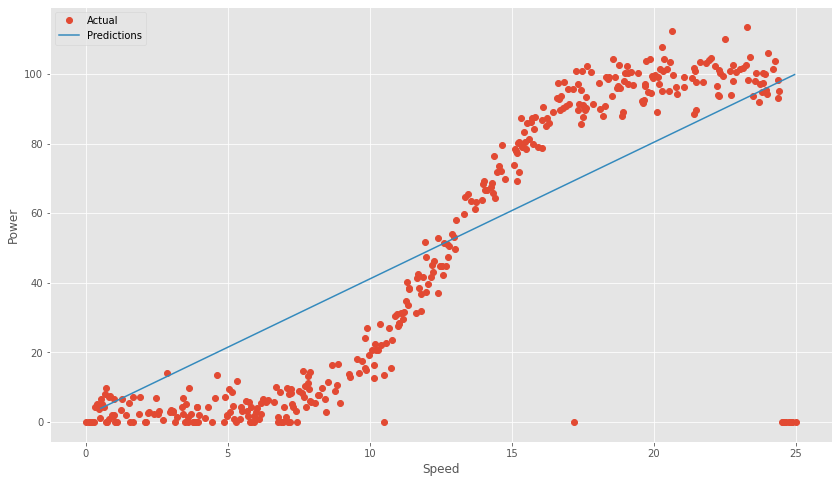

In [9]:
plot_predictions()

We can also predict individual values using Keras' `model.predict()` function. Below I find the predicted power output if the speed is 20, and then show where the result appears on the plot.

In [10]:
# Take a hand-picked speed value and view its predicted power
pred_speed = 20.0
pred_power = model.predict([pred_speed])[0]

pred_power

array([80.3734], dtype=float32)

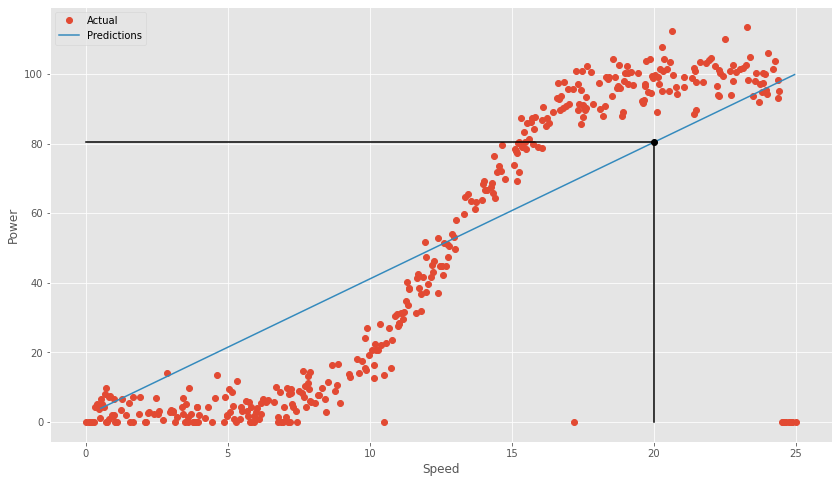

In [11]:
plot_predictions(pred_speed, pred_power)

As illustrated above, if we attempt to predict the power when the wind speed is 20, we get a value that is much lower than what we would expect. This is because the data in our dataset is not linear, and therefore linear regression is not the best form of regression to perform if we want to make more accurate predictions.

### Saving the Model

We can use `model.save()` to easily save the model for later use in the web application.

In [12]:
model.save("models/power_prod_lin.h5")

## Non-Linear Regression

Linear regression assumes that the relationship between an independent variable $x$ and a dependent variable $y$ can be best expressed with a line [4]. However, because the `powerproduction` dataset is non-linear, it would make more sense to do polynomial regression. Polynomial regression expresses the relationship between two variables as a polynomial curve [4].

Below I'll rebuild the model, this time using the *sigmoid* activation function. An activation function is simply a mathematical function that takes in an input and produces an output [5]. The function is activated when the computed result reaches a specified threshold and the output is then passed onto the neurons on the subsequent layer [5]. Like the shape of the `powerproduction` dataset, the sigmoid activation function is "S" shaped [5], making it the ideal choice for our model.

In [13]:
# Re-build the model
model = kr.models.Sequential()

model.add(
    kr.layers.Dense(
        64,
        input_shape=(1,),
        activation="sigmoid",
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform"
    )
)

model.add(
    kr.layers.Dense(
        64,
        activation="sigmoid",
    )
)

model.add(kr.layers.Dense(1, activation="linear"))

model.compile(kr.optimizers.Adam(lr=0.001), loss="mean_squared_error")

In [14]:
# Fit the data
model.fit(
    train.speed,
    train.power,
    epochs=150,
    batch_size=8
)

Epoch 1/150
50/50 [==============================] - 0s 1ms/step - loss: 3655.2081
Epoch 2/150
50/50 [==============================] - 0s 1ms/step - loss: 3559.5814
Epoch 3/150
50/50 [==============================] - 0s 766us/step - loss: 3009.6966
Epoch 4/150
50/50 [==============================] - 0s 810us/step - loss: 2674.0266
Epoch 5/150
50/50 [==============================] - 0s 735us/step - loss: 2849.3177
Epoch 6/150
50/50 [==============================] - 0s 672us/step - loss: 2572.3568
Epoch 7/150
50/50 [==============================] - 0s 515us/step - loss: 2507.1129
Epoch 8/150
50/50 [==============================] - 0s 957us/step - loss: 2582.3420
Epoch 9/150
50/50 [==============================] - 0s 988us/step - loss: 2276.9289
Epoch 10/150
50/50 [==============================] - 0s 638us/step - loss: 2289.1030
Epoch 11/150
50/50 [==============================] - 0s 771us/step - loss: 2175.8730
Epoch 12/150
50/50 [==============================] - 0s 638us/step

### Analysis

Once again, we can use this newly created model to make predictions. As done previously, I'll plot the values of the `train` dataset along with the predicted values of each point in the `test` dataset. Doing so, we'll find the predicted values appear to form a curved line.

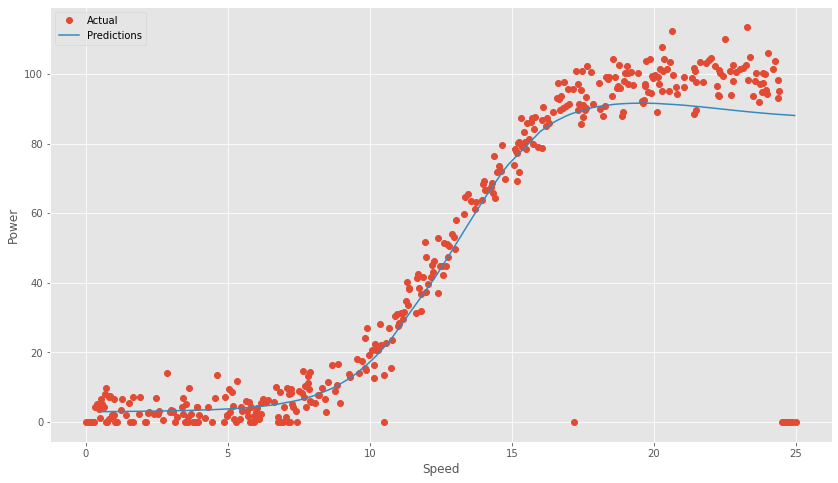

In [15]:
plot_predictions()

Again, we can provide an input speed of 20 to Keras' `model.predict()` function and plot the result.

In [16]:
pred_power = model.predict([pred_speed])[0]

pred_power

array([91.52989], dtype=float32)

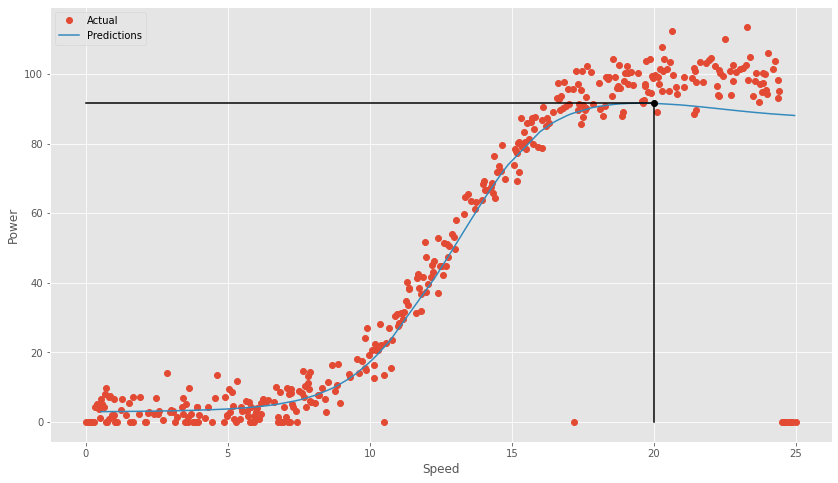

In [17]:
plot_predictions(pred_speed, pred_power)

We see that the result when using non-linear regression is much more accurate compared to the linear model tested previously. However the outliers in the data appear to decrease the accuracy of the modal as the speed increases. We can try creating a third model, but this time dropping these outliers from the `train` and `test` datasets.

In [18]:
# Save sigmoid model
model.save("models/power_prod_sig.h5")

## Removing Outliers

Below I'll repeat the same process carried out previously, but with the added step of disregarding all rows in the dataset which have a power output of zero.

In [19]:
# Remove items with a power of zero
# Ref: https://stackoverflow.com/a/55066805
train = train[train.power != 0]
test = test[test.power != 0]

In [20]:
# Re-build the model
model = kr.models.Sequential()

model.add(
    kr.layers.Dense(
        64,
        input_shape=(1,),
        activation="sigmoid",
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform"
    )
)

model.add(
    kr.layers.Dense(
        64,
        activation="sigmoid",
    )
)

model.add(kr.layers.Dense(1, activation="linear"))

model.compile(kr.optimizers.Adam(lr=0.001), loss="mean_squared_error")

In [21]:
# Fit the data
model.fit(
    train.speed,
    train.power,
    epochs=100,
    batch_size=8
)

Epoch 1/100
45/45 [==============================] - 0s 2ms/step - loss: 4382.1760
Epoch 2/100
45/45 [==============================] - 0s 1ms/step - loss: 3627.7525
Epoch 3/100
45/45 [==============================] - 0s 859us/step - loss: 3495.7376
Epoch 4/100
45/45 [==============================] - 0s 1ms/step - loss: 3415.1063
Epoch 5/100
45/45 [==============================] - 0s 1ms/step - loss: 3191.5719
Epoch 6/100
45/45 [==============================] - 0s 1000us/step - loss: 2807.0975
Epoch 7/100
45/45 [==============================] - 0s 568us/step - loss: 2895.8170
Epoch 8/100
45/45 [==============================] - 0s 614us/step - loss: 2743.3194
Epoch 9/100
45/45 [==============================] - 0s 659us/step - loss: 2611.1410
Epoch 10/100
45/45 [==============================] - 0s 773us/step - loss: 2620.7171
Epoch 11/100
45/45 [==============================] - 0s 661us/step - loss: 2533.9011
Epoch 12/100
45/45 [==============================] - 0s 389us/step - 

Again, we can make a prediction using this new model and show it on a plot.

In [22]:
pred_power = model.predict([pred_speed])[0]

pred_power

array([97.00156], dtype=float32)

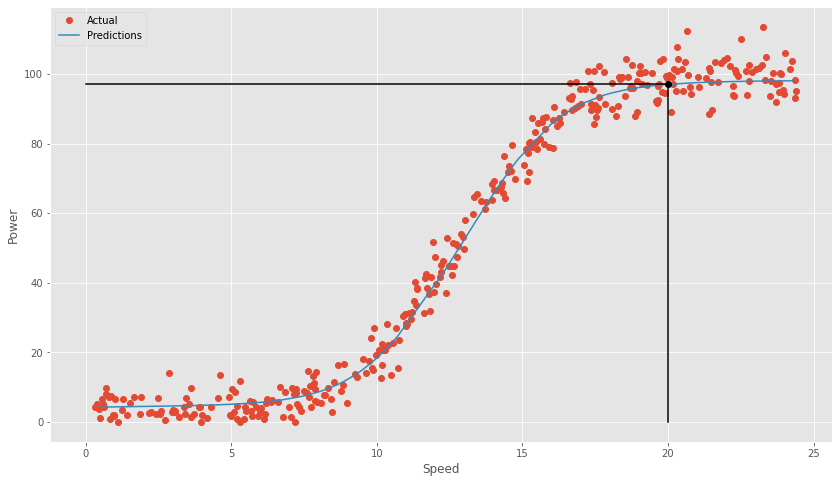

In [23]:
plot_predictions(pred_speed, pred_power)

As you can see, removing the outliers from the dataset significantly improves the accuracy of the model.

### Saving the Model

Finally, we can use `model.save()` to save this model for later use in the web application.

In [24]:
model.save("models/power_prod_signo.h5")

## References

1. [Train-Test Split for Evaluating Machine Learning Algorithms](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/). Jason Brownlee. Machine Learning Mastery.
2. [How Do Wind Turbines Survive Severe Storms?](https://www.energy.gov/eere/articles/how-do-wind-turbines-survive-severe-storms). US Office of Energy Efficiency & Renewable Energy.
3. [Linear Regression using Keras and Python](https://heartbeat.fritz.ai/linear-regression-using-keras-and-python-7cee2819a60c). Dhiraj K. Heartbeat.
4. [Polynomial Regression using tf.keras](https://medium.com/@anigasan637/polynomial-regression-using-tf-keras-17eaac771256). Ananya Gangavarapu. Medium.
5. [Neural Network Activation Function Types](https://medium.com/fintechexplained/neural-network-activation-function-types-a85963035196). Farhad Malik. Medium.